# Create model dataset
<br>
This file is used to create training and test data for a edge detection machine learning models. It crops the AOI tif files and vegetation shape files. 

In [26]:
import os
import glob
import numpy as np
import pandas as pd

import rasterio
from rasterio.plot import show
from rasterio.features import rasterize
from shapely.geometry import LineString

import matplotlib.pyplot as plt
import cv2

import geopandas as gpd
import random


# reimport 
import utils 
import importlib
importlib.reload(utils)

data_path = "/Users/conorosullivan/Documents/git/COASTAL_MONITORING/sentinel2-irish-coastal-segmentation/data"

In [27]:
veg_lines_path = os.path.join(data_path, "processed/vegetation_lines.shp")
veg_lines = gpd.read_file(veg_lines_path)
veg_lines.head()

ID  LINE      AOI  YEAR  \
0  20240330T114349_tramore   1.0  tramore  2024   
1  20241222T113409_tramore   1.0  tramore  2024   
2  20241127T113421_tramore   1.0  tramore  2024   
3  20241120T114401_tramore   1.0  tramore  2024   
4  20241021T114351_tramore   1.0  tramore  2024   

                                            geometry  
0  LINESTRING (627373.58 5780386.135, 627383.266 ...  
1  LINESTRING (627373.645 5780381.471, 627383.33 ...  
2  LINESTRING (627374.5 5780375.808, 627384.186 5...  
3  LINESTRING (627370.785 5780375.724, 627380.47 ...  
4  LINESTRING (627373.618 5780383.406, 627383.303...

In [28]:
processed_file_path = os.path.join(data_path, "processed", "meta", "processed_files.csv")
processed_files = pd.read_csv(processed_file_path)
processed_files = processed_files[processed_files["vegetation_line"] == True]
processed_files.head(5)

ID                                           filename  \
0  20241222T113409_tramore  S2B_MSIL2A_20241222T113409_N0511_R080_T29UPT_2...   
1  20241127T113421_tramore  S2A_MSIL2A_20241127T113421_N0511_R080_T29UPT_2...   
2  20241120T114401_tramore  S2A_MSIL2A_20241120T114401_N0511_R123_T29UPT_2...   
3  20241021T114351_tramore  S2A_MSIL2A_20241021T114351_N0511_R123_T29UPT_2...   
4  20241011T114351_tramore  S2A_MSIL2A_20241011T114351_N0511_R123_T29UPT_2...   

       aoi      left        top     right     bottom        date  year  \
0  tramore  624005.0  5783015.0  633005.0  5777015.0  2024-12-22  2024   
1  tramore  624005.0  5783015.0  633005.0  5777015.0  2024-11-27  2024   
2  tramore  624005.0  5783015.0  633005.0  5777015.0  2024-11-20  2024   
3  tramore  624005.0  5783015.0  633005.0  5777015.0  2024-10-21  2024   
4  tramore  624005.0  5783015.0  633005.0  5777015.0  2024-10-11  2024   

   vegetation_line  
0             True  
1             True  
2             True  
3             True  
4             True

In [34]:
# Get the in-location test IDs
locations = ["bull_island", "portmarnock", "portrane", "tramore"]
test_IDs_1 = []
for aoi in locations: 
    aoi_files = processed_files[processed_files["aoi"] == aoi]

    for year in aoi_files["year"].unique():
        year_files = aoi_files[aoi_files["year"] == year]
        test_IDs_1 += list(year_files["ID"].sample(n=1, random_state=42))

print(len(test_IDs_1))
print(test_IDs_1)

# Get the out-location test IDs
test_IDs_2 = processed_files[processed_files["aoi"] == "rossnowlagh"]["ID"].tolist()
print(len(test_IDs_2))
print(test_IDs_2)

train_IDs = processed_files[~processed_files["ID"].isin(test_IDs_1 + test_IDs_2)]["ID"].tolist()
print(len(train_IDs))

10
['20231022T114349_bull_island', '20190627T113321_bull_island', '20171129T113419_bull_island', '20190207T113321_portmarnock', '20171129T113419_portmarnock', '20240211T113311_portrane', '20220323T113321_portrane', '20200303T113311_portrane', '20190707T113321_portrane', '20240623T114351_tramore']
16
['20221211T114501_rossnowlagh', '20221204T115451_rossnowlagh', '20221116T114349_rossnowlagh', '20221007T114349_rossnowlagh', '20220922T114401_rossnowlagh', '20220910T115359_rossnowlagh', '20220905T115411_rossnowlagh', '20220813T114401_rossnowlagh', '20220811T115409_rossnowlagh', '20220722T115409_rossnowlagh', '20220607T115411_rossnowlagh', '20220604T114401_rossnowlagh', '20220523T115359_rossnowlagh', '20220408T115401_rossnowlagh', '20220326T114351_rossnowlagh', '20220319T115401_rossnowlagh']
89


### Functions to create training data

(900, 1000)
[0 1]


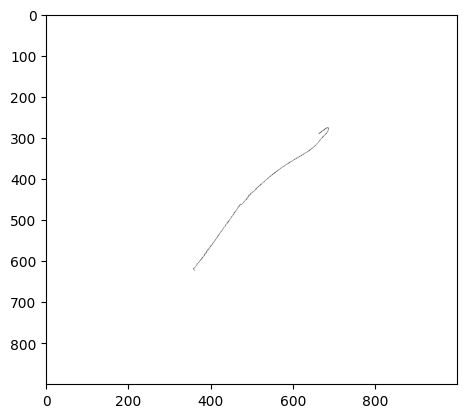

In [29]:
def get_line_mask(raster,line):
    """
    Get a mask of the line in the raster
    """
    line_mask = rasterize(
        [line.geometry],
        out_shape=raster.shape,
        transform=raster.transform,
        fill=0,
        dtype='uint8'
    )
    return line_mask

ID = "20170128T113321_bull_island"
example_raster_path = os.path.join(data_path, f"processed/aoi_crop/bull_island/2017/{ID}.tif")
example_raster = rasterio.open(example_raster_path)
veg_line = veg_lines[veg_lines['ID'] == ID].sample(n=1).iloc[0]

line_mask = get_line_mask(example_raster, veg_line)
print(line_mask.shape)
print(np.unique(line_mask))
plt.imshow(1-line_mask, cmap='gray')

2
POINT (688629.4180177618 5915255.479428639)
(900, 1000, 3)


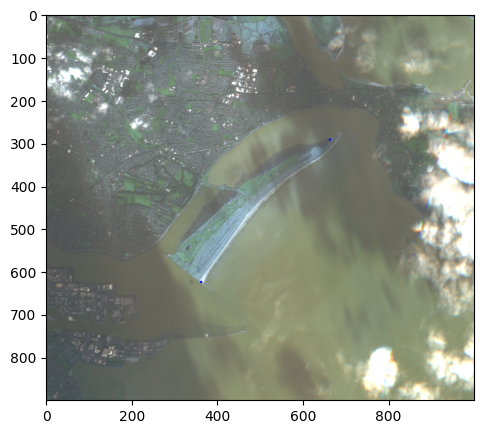

In [42]:
def get_points(line,m=100):
    """
    Convert a shapely geometry to a list of points
    """
   
    length = line.geometry.length

    # Get points every m meters along the line
    num_points = int(length / m)
    points = [line.geometry.interpolate(distance, normalized=False) 
            for distance in np.linspace(0, length, num_points)]
    
    # make sure start point is included
    first_point = line.geometry.coords[0]
    assert first_point == tuple(points[0].coords[0]), "First point does not match"

    # make sure end point is included
    last_point = line.geometry.coords[-1]
    assert last_point == tuple(points[-1].coords[0]), "Last point does not match"
    
    return points

points = get_points(veg_line,m=2000)
print(len(points))
print(points[0])

fig, ax = plt.subplots(1, 1, figsize=(10, 5))

rgb = example_raster.read()
rgb = utils.get_rgb(rgb ,contrast=0.3)
print(rgb.shape)
ax.imshow(rgb)

for point in points:
    utmx, utmy = point.x, point.y
    y, x = example_raster.index(utmx, utmy)
    ax.add_patch(plt.Circle((x, y), 1, color='blue', alpha=1))

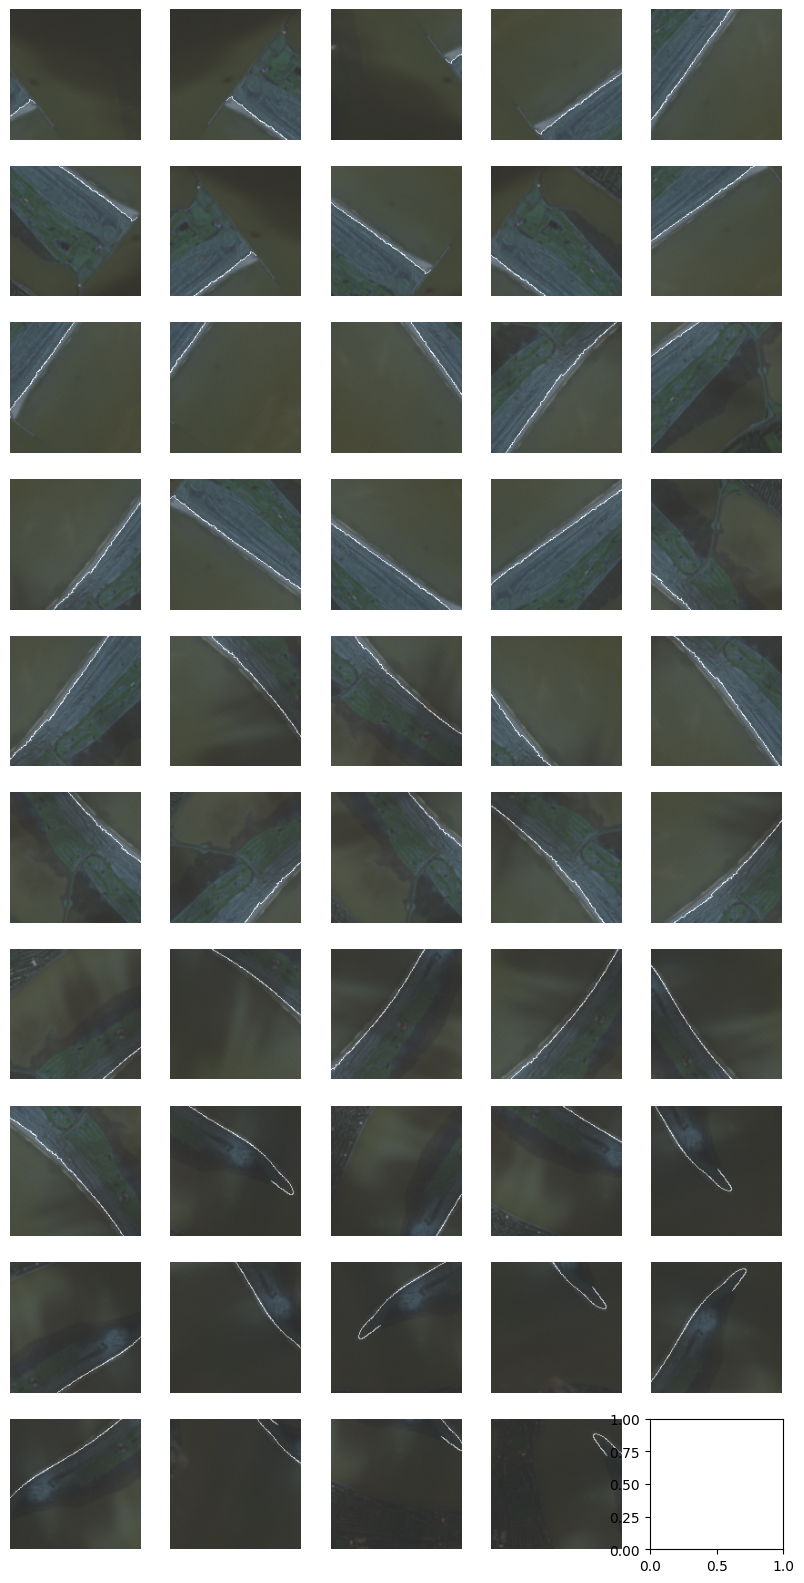

In [31]:
import numpy as np
from rasterio.windows import Window


def get_crops(raster, mask, points,crop_size=144,augmentation=True):
    instances = []

    for point in points:
        # Get the pixel coordinates of the point
        utmx, utmy = point.x, point.y
        y, x = raster.index(utmx, utmy)

        # Get cropped window centered around the point
        window_x = x - crop_size // 2 
        window_y = y - crop_size // 2

        # Offset the window by a random amount within the crop size
        window_x += np.random.randint(-crop_size // 2, crop_size // 2) 
        window_y += np.random.randint(-crop_size // 2, crop_size // 2)

        # Define the window for cropping
        window = Window(window_x, window_y, crop_size, crop_size)
        
        # Read 4-band image crop
        img_crop = raster.read(window=window)[0:4, :, :]
        
        # Extract corresponding mask crop
        mask_crop = mask[window_y:window_y+crop_size, window_x:window_x+crop_size]
        # Add a channel dimension to the mask crop
        mask_crop = np.expand_dims(mask_crop, axis=0)
        
        if augmentation:
            # Randomly flip the image and mask crops
            if np.random.rand() > 0.5:
                img_crop = np.flip(img_crop, axis=1) #axis 0 is bands, axis 1 is y, axis 2 is x
                mask_crop = np.flip(mask_crop, axis=1)
            if np.random.rand() > 0.5:
                img_crop = np.flip(img_crop, axis=2)
                mask_crop = np.flip(mask_crop, axis=2)
            
            # Randomly rotate the image and mask crops
            angle = np.random.choice([0, 90, 180, 270])
            img_crop = np.rot90(img_crop, k=angle//90, axes=(1, 2))
            mask_crop = np.rot90(mask_crop, k=angle//90, axes=(1, 2))
        
        
        instance = np.concatenate([img_crop, mask_crop], axis=0)
        instances.append(instance)

    return instances

instances = get_crops(example_raster, line_mask, points,augmentation=True)
fig,ax = plt.subplots(10, 5, figsize=(10, 20))
ax = ax.flatten().flatten()
for i in range(49):
    img_crop = instances[i][0:3, :, :]
    mask_crop = instances[i][4:5, :, :][0]
    rgb = utils.get_rgb(img_crop, contrast=0.3)
    ax[i].imshow(rgb)
    ax[i].imshow(mask_crop, alpha=0.5, cmap='gray')
    ax[i].axis('off')

## Training dataset

In [ ]:
for row in processed_files.iterrows():

    row = row[1]
    
    ID = row['ID']

    if ID in test_IDs_1 or ID in test_IDs_2:
        # Skip test IDs
        continue

    year = row['year']
    aoi = row['aoi']

    # Get raster 
    tif_filepath = os.path.join(data_path, f"processed/aoi_crop/{aoi}/{year}/{ID}.tif")

    if not os.path.exists(tif_filepath):
        print("File does not exist:", tif_filepath)
        continue

    raster =rasterio.open(tif_filepath)

    # Get number of lines from shape file
    veg_lines_id = veg_lines[veg_lines['ID'] == ID]
    lines = veg_lines_id['LINE'].unique()

    # We need to create a mask using all lines so they are present in all crops
    line_mask = np.zeros(raster.shape, dtype=np.uint8)
    for line in lines:
        veg_line = veg_lines_id[veg_lines_id['LINE'] == line]
        assert len(veg_line) == 1

        veg_line = veg_line.iloc[0] # Convert to series
        line_mask += get_line_mask(raster,veg_line)

    line_mask = np.clip(line_mask, 0, 1)  # Ensure mask is binary

    for line in lines:
        veg_line = veg_lines_id[veg_lines_id['LINE'] == line]
        veg_line = veg_line.iloc[0] # Convert to series

        points = get_points(veg_line,m=50)

        instances = get_crops(raster, line_mask, points,augmentation=True)
        assert len(instances) > 0
        print("ID:", ID, " | ", int(line), " | ", len(instances))

        # Save instances
        save_dir = os.path.join(data_path, "SIVE/training")
        os.makedirs(save_dir, exist_ok=True)

        filename = f"{ID}_line{int(line)}"
        for i, instance in enumerate(instances):
            assert instance.shape == (5, 144, 144)
            save_path = os.path.join(save_dir, f"{filename}_{i}.npy")
            np.save(save_path, instance)
 

ID: 20241222T113409_tramore  |  1  |  119
ID: 20241127T113421_tramore  |  1  |  119
ID: 20241120T114401_tramore  |  1  |  119
ID: 20241021T114351_tramore  |  1  |  119
ID: 20241011T114351_tramore  |  1  |  119
ID: 20240916T114349_tramore  |  1  |  119
ID: 20240814T113319_tramore  |  1  |  119
ID: 20240809T113321_tramore  |  1  |  119
ID: 20240728T114349_tramore  |  1  |  119
ID: 20240519T114349_tramore  |  1  |  119
ID: 20240511T113321_tramore  |  1  |  119
ID: 20240421T113321_tramore  |  1  |  119
ID: 20240330T114349_tramore  |  1  |  119
ID: 20240216T113319_tramore  |  1  |  119
ID: 20241127T113421_portrane  |  3  |  36
ID: 20241127T113421_portrane  |  1  |  34
ID: 20241127T113421_portrane  |  2  |  10
ID: 20241011T114351_portrane  |  1  |  34
ID: 20241011T114351_portrane  |  2  |  10
ID: 20241011T114351_portrane  |  3  |  36
ID: 20240916T114349_portrane  |  1  |  34
ID: 20240916T114349_portrane  |  3  |  36
ID: 20240916T114349_portrane  |  2  |  10
ID: 20240814T113319_portrane  |  2

In [92]:
# Calculate positive weight for wBCE
train_files = glob.glob(os.path.join(data_path, "SIVE/training", "*.npy"))
print("Number of files:", len(train_files))

positive = 0
total = 0
for file in train_files:
    instance = np.load(file)
    mask = instance[4, :, :]  # Get the mask channel
    positive += np.sum(instance[4] == 1)
    total += instance[4].shape[0] * instance[4].shape[1]

print("Positive pixels in test set:", positive)
print("Total pixels in test set:", total)
print("Postive weight:", round(total/positive))

Number of files: 8460
Positive pixels in test set: 1230338
Total pixels in test set: 175426560
Postive weight: 143


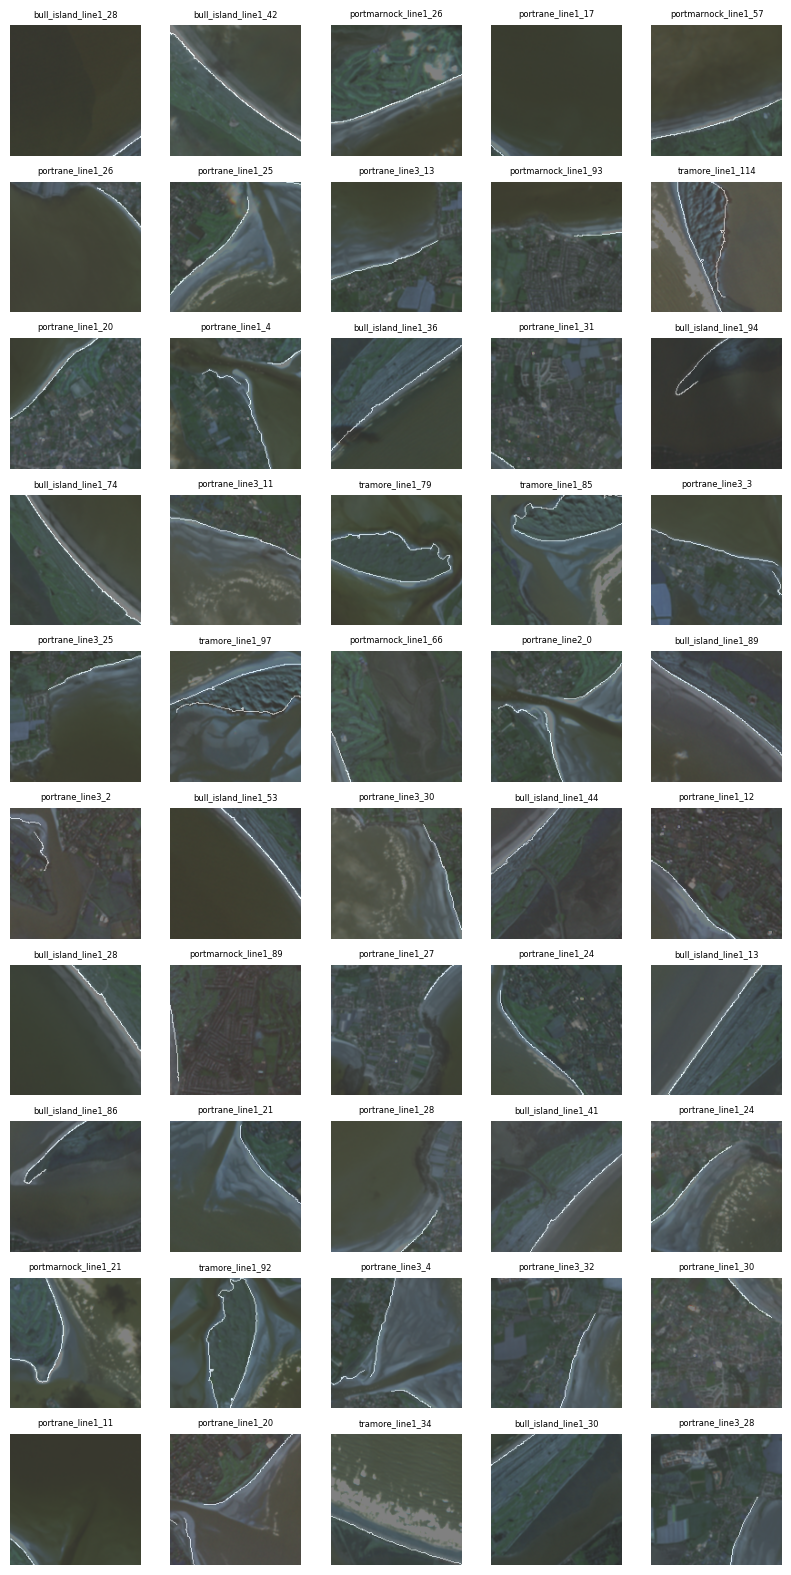

In [98]:
# Sense check training
test_files = glob.glob(os.path.join(data_path, "SIVE/training", "*.npy"))

fig,ax = plt.subplots(10, 5, figsize=(10, 20))
ax = ax.flatten().flatten()

for i in range(50):
    random_file = random.choice(test_files)
    file_name = os.path.basename(random_file)[16:-4]
    instance = np.load(random_file)

    img_crop = instance[0:4, :, :]
    mask_crop = instance[4]
    rgb = utils.get_rgb(img_crop, contrast=0.3)
    ax[i].imshow(rgb)
    ax[i].imshow(mask_crop, alpha=0.5, cmap='gray')
    ax[i].set_title(file_name, fontsize=6)
    ax[i].axis('off')

# Test set

In [35]:
def coords_to_pixel(raster, points):
    """
    Convert coordinates to pixel indices
    """
    pixel_points = []
    for point in points:
        utmx, utmy = point.x, point.y
        y, x = raster.index(utmx, utmy)
        pixel_points.append((x, y))
        
    return pixel_points

In [38]:
# Dictionary containing points for each ID
points_dict = {}

for row in processed_files.iterrows():

    row = row[1]
    ID = row['ID']
    year = row['year']
    aoi = row['aoi']

    if ID in train_IDs:
        # Skip train IDs
        continue
    elif ID in test_IDs_1:
        save_dir = os.path.join(data_path, "SIVE/test_1")
    elif ID in test_IDs_2:
        save_dir = os.path.join(data_path, "SIVE/test_2")
    
    os.makedirs(save_dir, exist_ok=True)

    # Get raster 
    tif_filepath = os.path.join(data_path, f"processed/aoi_crop/{aoi}/{year}/{ID}.tif")

    if not os.path.exists(tif_filepath):
        print("File does not exist:", tif_filepath)
        continue

    raster =rasterio.open(tif_filepath)

    # Get number of lines from shape file
    veg_lines_id = veg_lines[veg_lines['ID'] == ID]
    lines = veg_lines_id['LINE'].unique()

    # We need to create a mask using all lines so they are present in all crops
    line_mask = np.zeros(raster.shape, dtype=np.uint8)
    points = {}
    for line in lines:
        veg_line = veg_lines_id[veg_lines_id['LINE'] == line]
        assert len(veg_line) == 1

        veg_line = veg_line.iloc[0] # Convert to series
        line_mask += get_line_mask(raster,veg_line)
        
        # Get set of points along the line
        coord_points = get_points(veg_line,m=500)
        pixel_points = coords_to_pixel(raster, coord_points)
        points[line] = pixel_points

    line_mask = np.clip(line_mask, 0, 1)  # Ensure mask is binary    
    points_dict[ID] = points

    # Concatenate the line mask with the image bands
    img = raster.read()[0:4, :, :]
    mask = np.expand_dims(line_mask, axis=0)
    instance = np.concatenate([img, mask], axis=0)

    assert instance.shape[0] == 5
    assert instance.shape[1] == raster.height
    assert instance.shape[2] == raster.width

    save_path = os.path.join(save_dir, f"{ID}.npy")
    np.save(save_path, instance)
    print("Saved:", ID)

# Save the points dictionary to a file
points_dict_path = os.path.join(data_path, "SIVE", "points_dict.npy")
np.save(points_dict_path, points_dict)

Saved: 20240623T114351_tramore
Saved: 20221211T114501_rossnowlagh
Saved: 20221204T115451_rossnowlagh
Saved: 20221116T114349_rossnowlagh
Saved: 20221007T114349_rossnowlagh
Saved: 20220922T114401_rossnowlagh
Saved: 20220910T115359_rossnowlagh
Saved: 20220905T115411_rossnowlagh
Saved: 20220813T114401_rossnowlagh
Saved: 20220811T115409_rossnowlagh
Saved: 20220722T115409_rossnowlagh
Saved: 20220607T115411_rossnowlagh
Saved: 20220604T114401_rossnowlagh
Saved: 20220523T115359_rossnowlagh
Saved: 20220408T115401_rossnowlagh
Saved: 20220326T114351_rossnowlagh
Saved: 20220319T115401_rossnowlagh
Saved: 20240211T113311_portrane
Saved: 20220323T113321_portrane
Saved: 20200303T113311_portrane
Saved: 20190707T113321_portrane
Saved: 20190207T113321_portmarnock
Saved: 20171129T113419_portmarnock
Saved: 20231022T114349_bull_island
Saved: 20190627T113321_bull_island
Saved: 20171129T113419_bull_island


Number of test files: 10


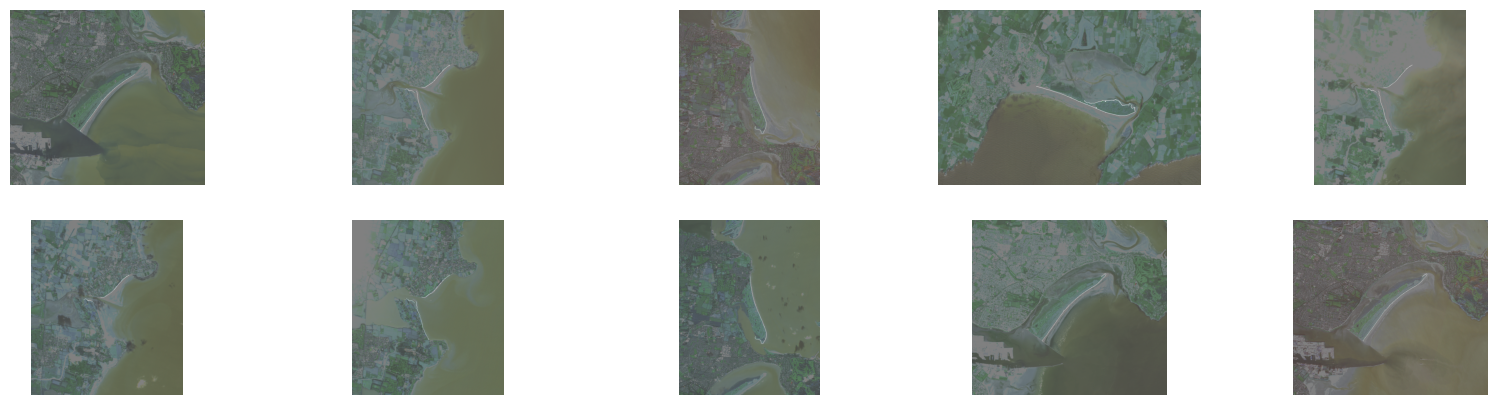

In [37]:
# Sense check training
test_files = glob.glob(os.path.join(data_path, "SIVE/test_1", "*.npy"))
print("Number of test files:", len(test_files))

fig,ax = plt.subplots(2, 5, figsize=(20,5))
ax = ax.flatten().flatten()

for i in range(10):
    instance = np.load(test_files[i])
    img_crop = instance[0:4, :, :]
    mask_crop = instance[4]
    rgb = utils.get_rgb(img_crop, contrast=0.2)

    ax[i].imshow(rgb)
    ax[i].imshow(mask_crop, alpha=0.5, cmap='gray')
    ax[i].axis('off')

Number of test files: 16


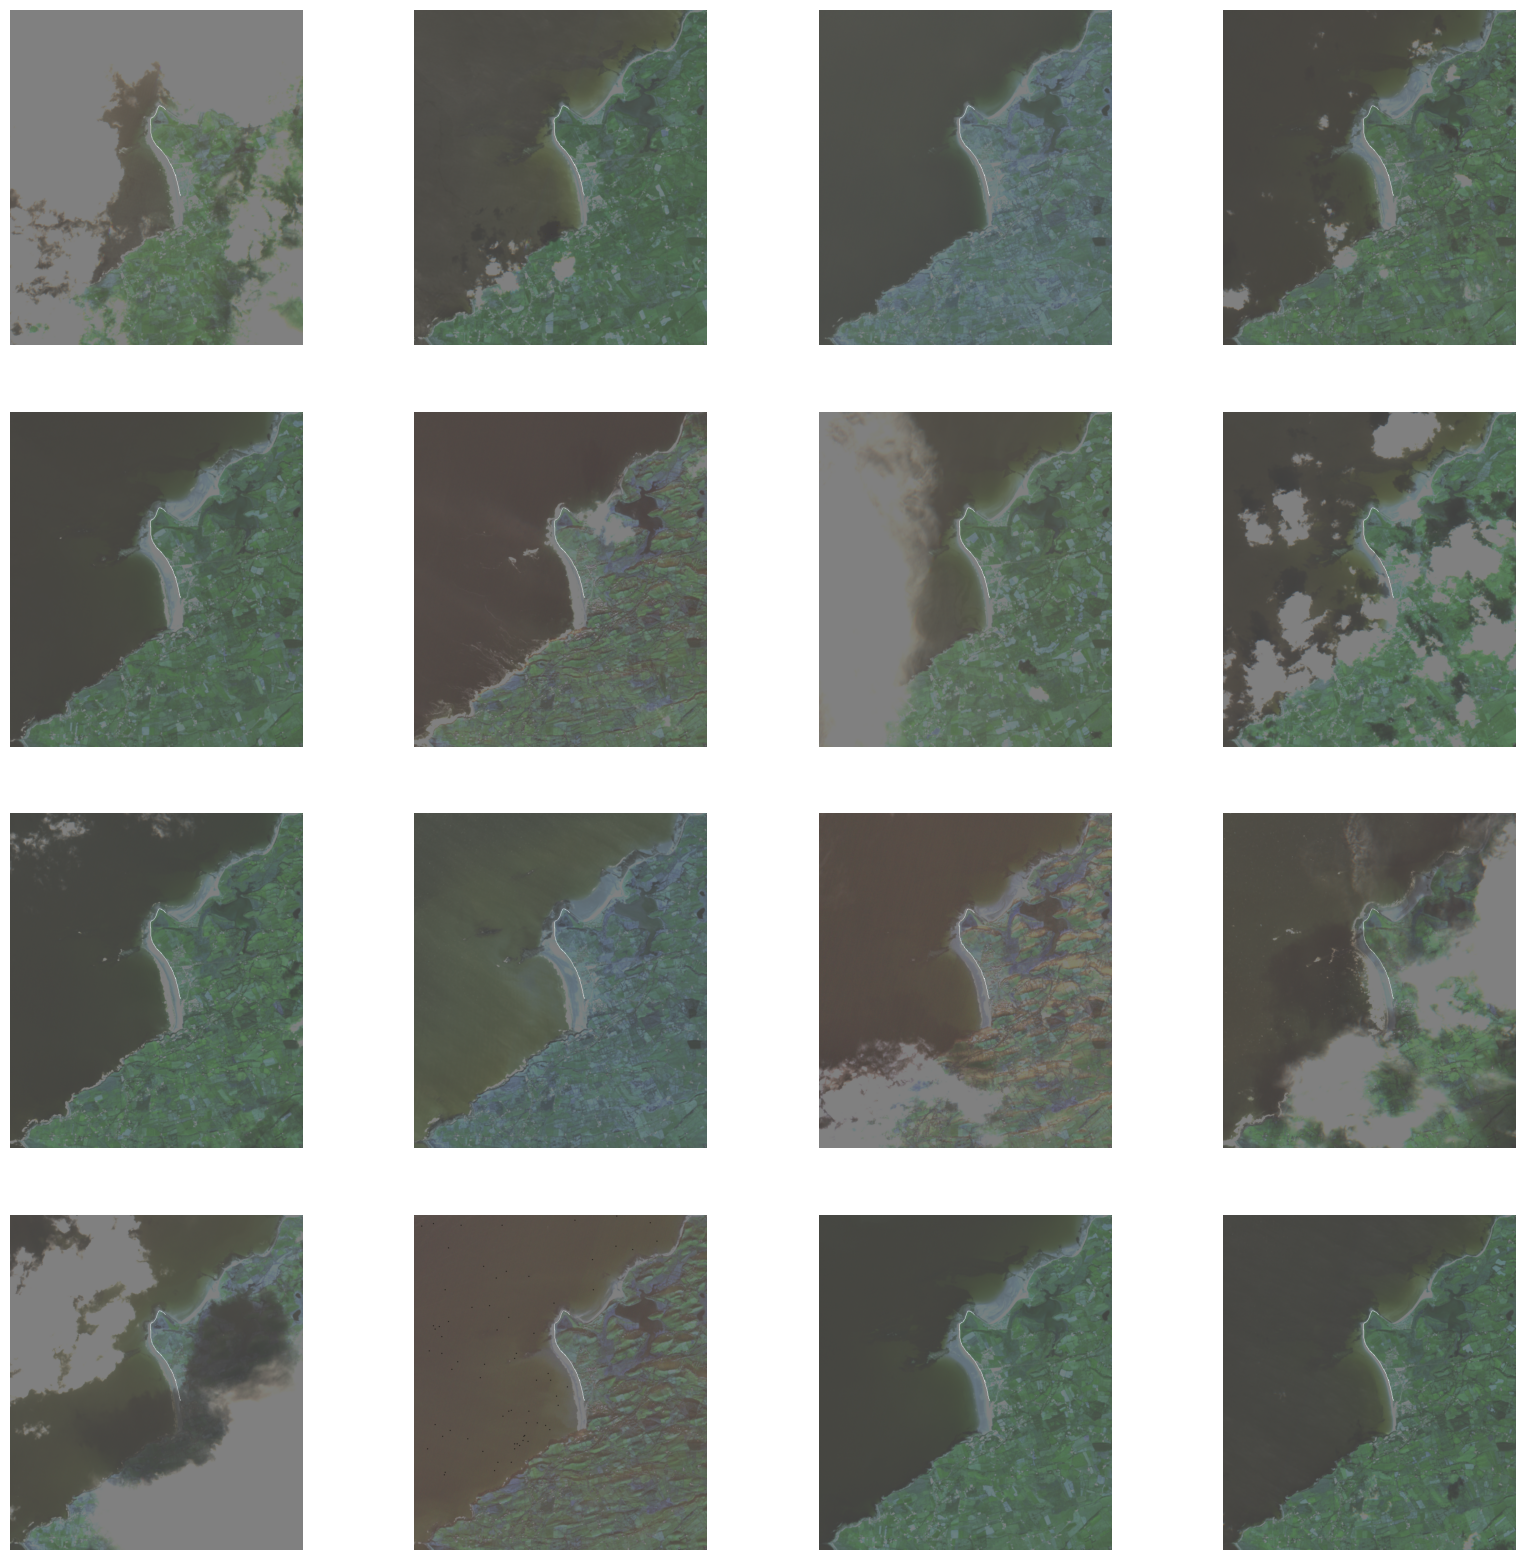

In [114]:
# Sense check training
test_files = glob.glob(os.path.join(data_path, "SIVE/test_2", "*.npy"))
print("Number of test files:", len(test_files))

fig,ax = plt.subplots(4, 4, figsize=(20,20))
ax = ax.flatten().flatten()

for i in range(16):
    instance = np.load(test_files[i])
    img_crop = instance[0:4, :, :]
    mask_crop = instance[4]
    rgb = utils.get_rgb(img_crop, contrast=0.2)

    ax[i].imshow(rgb)
    ax[i].imshow(mask_crop, alpha=0.5, cmap='gray')
    ax[i].axis('off')